In [57]:
import psutil
import numpy as np
import os

def get_memory_usage():
    """
    Gets and prints the current memory usage, available memory, and the
    size of a given numpy array (if provided).
    """

    # Get memory information
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    virtual_mem = psutil.virtual_memory()

    # Print current process memory usage
    print(f"Current process memory usage: {mem_info.rss / (1024 ** 2):.2f} MB")
    print(f"   Resident Set Size (RSS): {mem_info.rss / (1024 ** 2):.2f} MB")  # Actual physical memory
    print(f"   Virtual Memory Size (VMS): {mem_info.vms / (1024 ** 2):.2f} MB") # Total memory (including swap)

    # Print system-wide memory usage
    print(f"\nSystem-wide memory usage:")
    print(f"   Total: {virtual_mem.total / (1024 ** 2):.2f} MB")
    print(f"   Available: {virtual_mem.available / (1024 ** 2):.2f} MB")
    print(f"   Used: {virtual_mem.used / (1024 ** 2):.2f} MB")
    print(f"   Free: {virtual_mem.free / (1024 ** 2):.2f} MB")  # Actually free (not including buffers/cache)
    print(f"   Percent Used: {virtual_mem.percent:.1f}%")

def get_array_memory_size(array):
    """
    Calculates the memory size of a NumPy array in MB.

    Args:
        array: The NumPy array.

    Returns:
        The size of the array in MB.
    """
    return array.nbytes / (1024 ** 2)



def check_memory_for_array(rows, cols, dtype=np.float64):
    """
    Checks if there's enough memory to create a NumPy array of the given shape
    and data type, and prints relevant memory information.

    Args:
        rows: The number of rows in the array.
        cols: The number of columns in the array.
        dtype: The NumPy data type (default: np.float64).
    """

    print(f"\nChecking memory for an array of shape ({rows}, {cols}) with dtype {dtype}:")
    
    # Get available memory *before* creating the array
    available_memory_mb = psutil.virtual_memory().available / (1024 ** 2)
    print(f"Available memory (before array creation): {available_memory_mb:.2f} MB")


    # Calculate the required memory
    try:
        #Try to actually make the array.  This is the best way to check
        test_array = np.empty((rows, cols), dtype=dtype)
        required_memory_mb = get_array_memory_size(test_array)
        del test_array  #Immediately delete to try to free the memory
        print(f"Required memory for the array: {required_memory_mb:.2f} MB")
        if required_memory_mb > available_memory_mb:
             print(f"Insufficient memory available!  Need {required_memory_mb:.2f} MB, but only have {available_memory_mb:.2f} MB available.")
        else:
            print("Sufficient memory available.")
    except MemoryError:
        # Calculate required size even if we can't create it.
        element_size = np.dtype(dtype).itemsize  # Size of each element in bytes
        required_memory_mb = (rows * cols * element_size) / (1024 ** 2)
        print(f"Required memory for the array: {required_memory_mb:.2f} MB")
        print("MemoryError:  Could not create array to test, insufficient memory")



# --- Example Usage ---
if __name__ == "__main__":
    get_memory_usage()

    # Example 1: Check for the array size from your original error
    check_memory_for_array(12170750, 50, np.float64)

    # Example 2: Check for a smaller array (likely to succeed)
    check_memory_for_array(1000, 100, np.float32)

    # Example 3. Check with a small dataset to confirm that it will work,
    # even if larger datasets fail.
    check_memory_for_array(100, 5, np.float64)

Current process memory usage: 1725.75 MB
   Resident Set Size (RSS): 1725.75 MB
   Virtual Memory Size (VMS): 3122.71 MB

System-wide memory usage:
   Total: 16025.11 MB
   Available: 8703.36 MB
   Used: 7321.75 MB
   Free: 8703.36 MB
   Percent Used: 45.7%

Checking memory for an array of shape (12170750, 50) with dtype <class 'numpy.float64'>:
Available memory (before array creation): 8700.44 MB
Required memory for the array: 4642.77 MB
Sufficient memory available.

Checking memory for an array of shape (1000, 100) with dtype <class 'numpy.float32'>:
Available memory (before array creation): 8700.14 MB
Required memory for the array: 0.38 MB
Sufficient memory available.

Checking memory for an array of shape (100, 5) with dtype <class 'numpy.float64'>:
Available memory (before array creation): 8700.14 MB
Required memory for the array: 0.00 MB
Sufficient memory available.


In [58]:
# Import required libraries
import segyio
import numpy as np
import pandas as pd
import dask.array as da
import dask.dataframe as ddf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Dict, List, Tuple, Callable
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
print ("Libraries imported successfully!")

Libraries imported successfully!


In [61]:
# load the Models
import joblib
LR = joblib.load(r'E:\Datasets\reservior_simulation\models\linear_regression_model.pkl')
RFR = joblib.load(r'E:\Datasets\reservior_simulation\models\neural_network_model.pkl')
NN = joblib.load(r'E:\Datasets\reservior_simulation\models\random_forest_model.pkl')
print("Models loaded successfully!")

Models loaded successfully!


In [62]:
seismic_data_path = r'E:\Datasets\reservior_simulation\Input Data-20250215T124539Z-001\Input Data\F3_Seismic_C.sgy'  # Store the file path
seismic_data = segyio.tools.cube(seismic_data_path)  # Load data using the path

In [63]:
# Inspect Seismic Data
with segyio.open(seismic_data_path, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)

f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms, Trace length: {max(twt)}'

'N Traces: 80601, N Samples: 151, Sample rate: 4.0ms, Trace length: 1100.0'

In [64]:
f = segyio.open(seismic_data_path, xline=segyio.tracefield.TraceField.CDP)
il, xl, t = f.ilines, f.xlines, f.samples
dt = t[1] - t[0]

d = segyio.cube(f)
nil, nxl, nt = d.shape
itmin,itmax = int(t[0]), int(t[-1])

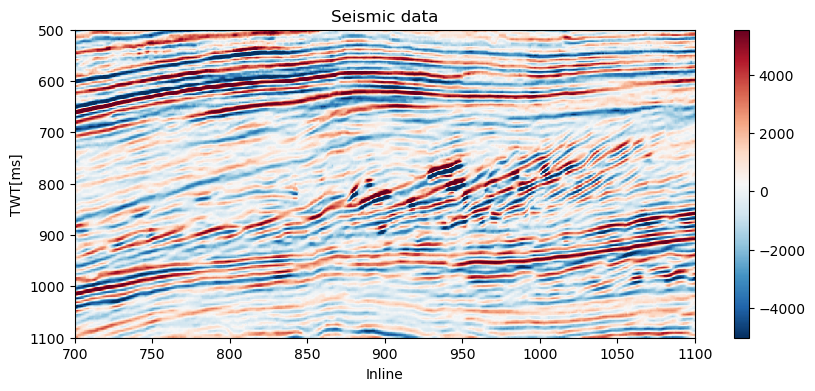

In [65]:
# Plot seismic section
plt.figure(figsize=(10, 4))
plt.imshow(d[100,:,:].T, cmap='RdBu_r',
           extent=(xl[0], xl[-1], t[-1], t[0]),
           vmin=np.percentile(d, 2),
           vmax=np.percentile(d, 98))
plt.title('Seismic data')
plt.colorbar()
plt.axis('tight')
plt.xlabel('Inline')
plt.ylabel('TWT[ms]')
plt.show()

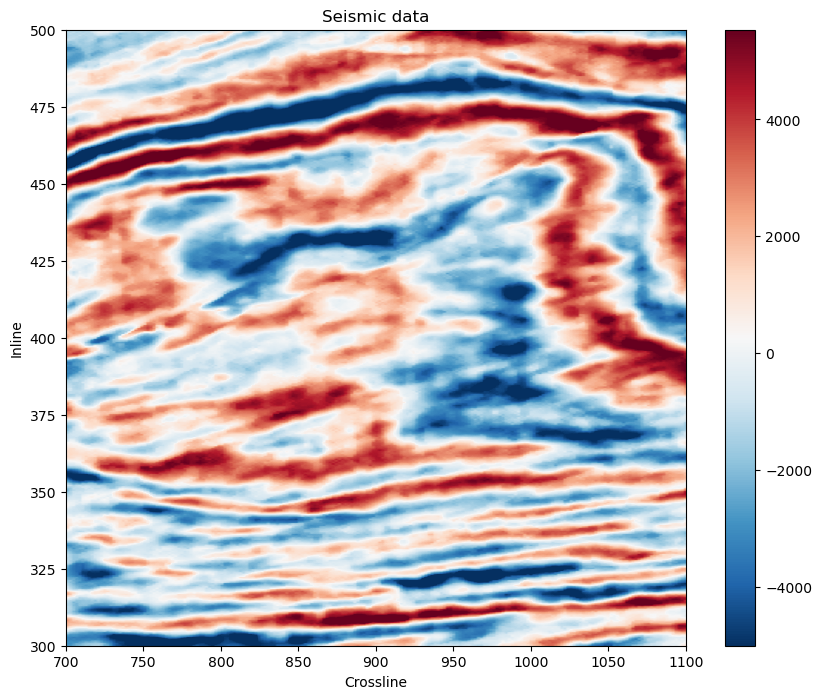

In [66]:
# Plot time slice
plt.figure(figsize=(10, 8))
plt.imshow(d[:,:,120].T, cmap='RdBu_r',
           extent=(xl[0], xl[-1], il[0], il[-1]),
           vmin=np.percentile(d, 2),
           vmax=np.percentile(d, 98))
plt.title('Seismic data')
plt.colorbar()
plt.axis('tight')
plt.xlabel('Crossline')
plt.ylabel('Inline')
plt.show()

In [67]:
# Load seismic attributes
# Velocity
seismic_velocity_path = r'E:\Datasets\reservior_simulation\Input Data-20250215T124539Z-001\Input Data\F3_Velocity_C.sgy'  # Store the file path
F3_Velocity = segyio.tools.cube(seismic_velocity_path)  # Load data using the path

# Energy
seismic_Energy_path = r'E:\Datasets\reservior_simulation\Input Data-20250215T124539Z-001\Input Data\energy.sgy'  
Energy = segyio.tools.cube(seismic_Energy_path)  

# env_w_phase
seismic_env_w_phase_path =  r'E:\Datasets\reservior_simulation\Input Data-20250215T124539Z-001\Input Data\env_w_phase.sgy'
env_w_phase = segyio.tools.cube(seismic_env_w_phase_path) 

# hilbert
seismic_hilbert_path =  r'E:\Datasets\reservior_simulation\Input Data-20250215T124539Z-001\Input Data\hilbert.sgy'
hilbert = segyio.tools.cube(seismic_hilbert_path) 

# Inst_Amp
seismic_Inst_Amp_path =  r'E:\Datasets\reservior_simulation\Input Data-20250215T124539Z-001\Input Data\insta_amp.sgy'
Inst_Amp = segyio.tools.cube(seismic_hilbert_path) 

# p_relief
seismic_p_relief_path =  r'E:\Datasets\reservior_simulation\Input Data-20250215T124539Z-001\Input Data\p_relief.sgy' 
p_relief = segyio.tools.cube(seismic_p_relief_path) 

print ("Data loaded successfully!")

Data loaded successfully!


## Flatten the seismic attributes 3D cubes

In [68]:
Velocity_f= F3_Velocity.flatten()
Energy_f= Energy.flatten()
env_w_phase_f= env_w_phase.flatten()
hilbert_f= hilbert.flatten()
Inst_Amp_f= insta_freq.flatten()
p_relief_f= p_relief.flatten()


# Create list to make a dataframe of the Seismic 3D cubes
names = ['F3_Velocity_Data', 'Energy', 'Hilbert', 'Relief', 'Env_w_Phase']
seismic_df = [Velocity_f, Energy_f, hilbert_f, p_relief_f, env_w_phase_f]


# Create daskdataframe of the Seismic 3D cubes
seismic_df = da.stack(seismic_df, axis=1)
seismic_df = ddf.from_dask_array(seismic_df, columns=names).compute()

# check results
seismic_df

,F3_Velocity_Data,Energy,Hilbert,Relief,Env_w_Phase
0,1934.559570,3242441.0,-1077.727295,-4.458501e+06,-0.468112
1,1937.196045,3301170.0,-2274.618164,6.163898e+05,-1.758222
2,1939.779541,3291144.0,-2290.942383,2.954568e+06,-0.882115
3,1942.311035,2552251.0,-27.140488,9.566294e+05,0.061363
4,1944.791992,2497124.0,2656.842285,-6.434117e+06,0.935588
...,...,...,...,...,...
12170746,2067.752686,3203037.0,707.257812,-1.602355e+06,0.268522
12170747,2067.870361,3142902.0,2166.420410,-7.634472e+05,1.170774
12170748,2067.976074,2648209.0,2161.849121,1.516097e+06,1.936398
12170749,2068.069824,3641713.0,993.804932,3.302810e+06,0.802396


In [69]:
# Initialize the StandardScaler
scaler = StandardScaler()
# Fit the scaler on the data and transform it
seismic_df_sc = scaler.fit_transform(seismic_df)

# Convert the result back to a DataFrame
seismic_df_std = pd.DataFrame(seismic_df_sc, columns=seismic_df.columns)

# check results
seismic_df_std

,F3_Velocity_Data,Energy,Hilbert,Relief,Env_w_Phase
0,-2.446964,-0.493709,-0.450685,-0.436305,-0.404955
1,-2.367978,-0.481951,-0.952545,0.082088,-1.580559
2,-2.290579,-0.483958,-0.959389,0.320930,-0.782213
3,-2.214738,-0.631888,-0.010171,0.116843,0.077526
4,-2.140411,-0.642924,1.115231,-0.638112,0.874158
...,...,...,...,...,...
12170746,1.543362,-0.501597,0.297765,-0.144554,0.266298
12170747,1.546888,-0.513637,0.909596,-0.058860,1.088469
12170748,1.550055,-0.612677,0.907679,0.173992,1.786139
12170749,1.552863,-0.413772,0.417915,0.356503,0.752787


# apply the model to the seismic data


In [86]:
# 1. Linear Regression Model

%time
Predicted_Porosity_LR = LR.predict(seismic_df_std)
print("LR Model applied successfully!")

CPU times: total: 0 ns
Wall time: 0 ns
LR Model applied successfully!


In [87]:
# 2. Random Forest Model

%time
Predicted_Porosity_RFR = RFR.predict(seismic_df_std)
print("RFR Model applied successfully!")

CPU times: total: 0 ns
Wall time: 0 ns
RFR Model applied successfully!


In [88]:
# 3. Neural Network Model

%time
Predicted_Porosity_NN = NN.predict(seismic_df_std)
print("MLP Model applied successfully!")

CPU times: total: 0 ns
Wall time: 0 ns
MLP Model applied successfully!


In [89]:
# Reshape resultant volumes
Porosity_LR = Predicted_Porosity_LR.reshape(seismic_data.shape)
Porosity_RFR = Predicted_Porosity_RFR.reshape(seismic_data.shape)
Porosity_NN = Predicted_Porosity_NN.reshape(seismic_data.shape)
print("Reshaped successfully!")

Reshaped successfully!


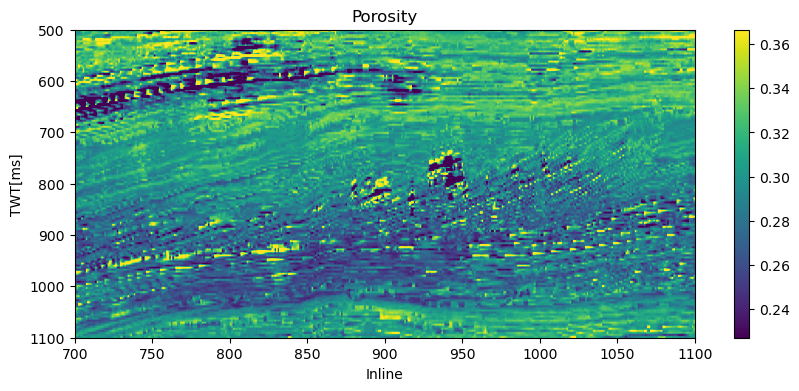

In [95]:
# Plotting Porosity Section
plt.figure(figsize=(10, 4))
plt.imshow(Porosity_RFR[100,:,:].T, cmap='viridis',
           extent=(xl[0], xl[-1], t[-1], t[0]),
           vmin=np.percentile(Porosity_RFR, 2),
           vmax=np.percentile(Porosity_RFR, 98))
plt.title('Porosity')
plt.colorbar()
plt.axis('tight')
plt.xlabel('Inline')
plt.ylabel('TWT[ms]')
plt.show()

# Export the Porosity

In [91]:
#@title Export the Porosity
import h5py
from d2geo.attributes.io import segy_read, segy_write
from shutil import copyfile as cf
output = segy_write(Porosity_LR, seismic_data_path, r'E:\Datasets\reservior_simulation\predict\Porosity_LR.segy')
print('Done Exporting')

E:\Programs\anaconda\Lib\site-packages\segyio\utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)


Done Exporting


In [92]:
output = segy_write(Porosity_RFR, seismic_data_path, r'E:\Datasets\reservior_simulation\predict\Porosity_RFR.segy')
print('Done Exporting')

Done Exporting


In [93]:
output = segy_write(Porosity_NN, seismic_data_path, r'E:\Datasets\reservior_simulation\predict\Porosity_NN.segy')
print('Done Exporting')

Done Exporting
